# CIFAR10 with MLPs
Simple starter notebook to benchmark your own MLP with PyTorch on the CIFAR-10 dataset.

OBS.:

- The main code is basically done, so focus on training the models and searching for the best hyperparameters and architectures.
- You are not required to use this exact code or even the PyTorch library.
- It is recommended to use execution environments with GPU access (such as Google Colab), since larger models will take more time to train.
- Remember to document the history of your experiments and which results motivated the changes in subsequent experiments.

## Como tentamos melhorar o modelo:
- Utilizamos o optuna para encontrar melhores hiperparâmetros: learning rate, número de nós em cada camada e função de ativação
- Evitar overfiting:
    - Regularização com weight_decay no otimizador para diminuir a magnitude dos pesos
    - Uso de dropout para desativar 20% dos neurônios
    - separação do dataset de treinamento em treinamento e validação
    - Uso de early stopping levando em conta o loss da validação

In [33]:
!pip install optuna

In [34]:
#@title Libs

import torch
from torch.utils.data import DataLoader

import torchvision
import torch.nn as nn
from torchvision import datasets, transforms

from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset

import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

from tqdm import tqdm

import os
from collections import Counter

import optuna

# Data exploration

Quando usamos transforms.ToTensor(), a imagem (que antes era H x W x C) vira um tensor com shape: C x H x W

O matplotlib.pyplot.imshow() espera a imagem no formato H x W x C (como a maioria das bibliotecas de imagem em Python).


In [4]:
# Função para "desnormalizar" e mostrar imagens
def imshow(img):
    img = img / 2 + 0.5  # desfaz a normalização
    img = torch.clamp(img, 0, 1)  # limita os valores ao intervalo [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  
])

dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform= transform)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

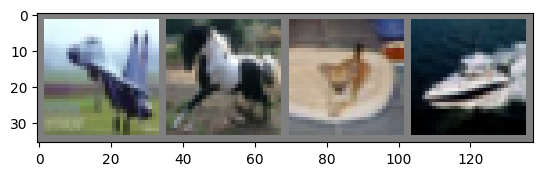

airplane horse dog ship


In [6]:
# Itera no loader e mostra imagens
dataiter = iter(loader)
images, labels = next(dataiter)

# Mostra as imagens
imshow(torchvision.utils.make_grid(images))

# Mostra os rótulos correspondentes
print(' '.join(f'{dataset.classes[label]}' for label in labels))

In [31]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [32]:
# Extraímos todos os rótulos do dataset de treino e ignoramos as imagens
labels = [label for _, label in dataset]

# Contamos quantas vezes cada rótulo aparece
label_counts = Counter(labels)

# Imprimimos o resultado com nome da classe
for class_idx, count in label_counts.items():
    class_name = dataset.classes[class_idx]
    print(f'{class_name}: {count} imagens')

frog: 5000 imagens
truck: 5000 imagens
deer: 5000 imagens
automobile: 5000 imagens
bird: 5000 imagens
horse: 5000 imagens
ship: 5000 imagens
cat: 5000 imagens
dog: 5000 imagens
airplane: 5000 imagens


Scores of the first model:
  'accuracy': 0.474, 'balanced_accuracy': np.float64(0.47400000000000003), 'precision': 0.4788458695520801, 'recall': 0.474, 'f1_score': 0.4749641894435279



Começamos a treinar uma mlp com 4 camadas usando imagens com 3 canais (RGB) , depois transformamos as imagens para a escala de cinza

In [6]:
#@title Defining the MLP model

class MLP(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, num_classes, activation_function):
        super(MLP, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_size, hidden1),
            activation_function,
            nn.Dropout(0.2),
            nn.Linear(hidden1, hidden2),
            activation_function,
            nn.Dropout(0.2),
            nn.Linear(hidden2, num_classes)
        )

    def forward(self, x):
        return self.network(x)

## Hyperparameters Study



In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def objective(trial):

    # Hiperparâmetros sugeridos pelo Optuna
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    hidden1 = trial.suggest_int("hidden1", 64, 256)
    hidden2 = trial.suggest_int("hidden2", 64, 256)
    activation_name = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU", "ELU"])

    activation_fn = getattr(nn, activation_name)()

    # Dataset e DataLoader (usa apenas um subset para acelerar)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    val_dataset, _ = torch.utils.data.random_split(train_dataset, [5000, len(train_dataset)-5000])
    train_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

    model = MLP(32*32*3,
                hidden1= hidden1,
                hidden2= hidden2,
                num_classes = 10,
                activation_function = activation_fn)

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Treinamento simples de 1-3 épocas (rápido)
    for epoch in range(3):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.view(-1, 32*32*3).to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

    # Retorna a perda média como métrica a minimizar
    return running_loss / len(train_loader)

In [8]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

[I 2025-05-28 19:37:05,369] A new study created in memory with name: no-name-ee79bd67-3590-4b9b-b55c-270804498c11
[I 2025-05-28 19:37:08,969] Trial 0 finished with value: 1.6627939169919943 and parameters: {'lr': 0.00354294282916484, 'hidden1': 200, 'hidden2': 126, 'activation': 'ELU'}. Best is trial 0 with value: 1.6627939169919943.
[I 2025-05-28 19:37:12,193] Trial 1 finished with value: 2.2131995762450787 and parameters: {'lr': 1.576471340752689e-05, 'hidden1': 86, 'hidden2': 164, 'activation': 'LeakyReLU'}. Best is trial 0 with value: 1.6627939169919943.
[I 2025-05-28 19:37:15,417] Trial 2 finished with value: 2.1194818291483046 and parameters: {'lr': 2.5717943523055473e-05, 'hidden1': 155, 'hidden2': 129, 'activation': 'ReLU'}. Best is trial 0 with value: 1.6627939169919943.
[I 2025-05-28 19:37:18,623] Trial 3 finished with value: 1.7613909485973889 and parameters: {'lr': 0.0036795222414442775, 'hidden1': 132, 'hidden2': 221, 'activation': 'LeakyReLU'}. Best is trial 0 with value:

In [9]:
print("Melhores hiperparâmetros:")
print(study.best_params)

Melhores hiperparâmetros:
{'lr': 0.0007981108590240665, 'hidden1': 218, 'hidden2': 119, 'activation': 'ELU'}


In [27]:
#@title Hyperparameters
input_size = 32*32*3 # 32x32 RGB images
num_classes = 10

learning_rate = 0.0008
num_epochs = 30
batch_size = 16
hidden1 = 218
hidden2 = 119

activation_function = nn.LeakyReLU()

loss_function = nn.CrossEntropyLoss()

In [11]:
#@title Dataset Setup

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_val_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


In [12]:
def evaluate(model, val_loader, loss_function):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.view(-1, 32*32*3).to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
    model.train()
    return val_loss / len(val_loader)

In [13]:
# Extrai os rótulos
targets = np.array(train_val_dataset.targets)

# Cria o validador estratificado
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Gera os índices
for train_idx, val_idx in splitter.split(np.zeros(len(targets)), targets):
    train_dataset = Subset(train_val_dataset, train_idx)
    val_dataset = Subset(train_val_dataset, val_idx)

In [14]:
# Acessa os rótulos (targets) do val_dataset
val_targets = [train_val_dataset[idx][1] for idx in val_dataset.indices]

# Conta quantas vezes cada classe aparece
val_distribution = Counter(val_targets)

print("Distribuição de classes no val_dataset:")
for label, count in sorted(val_distribution.items()):
    print(f"Classe {label}: {count} amostras")

Distribuição de classes no val_dataset:
Classe 0: 1000 amostras
Classe 1: 1000 amostras
Classe 2: 1000 amostras
Classe 3: 1000 amostras
Classe 4: 1000 amostras
Classe 5: 1000 amostras
Classe 6: 1000 amostras
Classe 7: 1000 amostras
Classe 8: 1000 amostras
Classe 9: 1000 amostras


In [15]:
#@title Loaders

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [35]:
#@title Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Build the model
mlp = MLP(32*32*3,
                hidden1= hidden1,
                hidden2= hidden2,
                num_classes = 10,
                activation_function = activation_function)
mlp.to(device)

# Setting optimizer up
optimizer = torch.optim.AdamW(mlp.parameters(), lr=learning_rate, weight_decay = 1e-4)

# Early stopping setup
best_loss = float('inf')
patience = 5
patience_counter = 0
best_model_state = None

train_losses = []
val_losses = []

# Start training epochs loop
for epoch in tqdm(range(num_epochs)):
  epoch_loss = 0.0
  for i, (images, labels) in enumerate(train_loader):
    images = images.view(-1,32*32*3).to(device) # flattenning images
    labels = labels.to(device)

    # Forward pass
    optimizer.zero_grad()
    outputs = mlp(images)

    # Backward pass
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

    if (i+1) % 1000 == 0:
      tqdm.write(f' Epoch {epoch + 1}/{num_epochs}, Step {i+1}/{len(train_dataset) // batch_size}, Loss: {loss}')

  epoch_loss /= len(train_loader)
  tqdm.write(f'Epoch {epoch+1} average loss: {epoch_loss:.4f}')
  train_losses.append(epoch_loss)

  val_loss = evaluate(mlp, val_loader, loss_function)
  tqdm.write(f'Epoch {epoch+1} validation loss: {val_loss:.4f}')
  val_losses.append(val_loss)

  # Early stopping using loss value
  if val_loss < best_loss:
    best_loss = val_loss
    patience_counter = 0
    best_model_state = mlp.state_dict()
  else:
    patience_counter += 1
    if patience_counter >= patience:
      tqdm.write("Early stopping triggered.")
      break

if best_model_state is not None:
    mlp.load_state_dict(best_model_state)
    torch.save(mlp.state_dict(), "melhor_modelo.pth")


  0%|          | 0/30 [00:03<?, ?it/s]

 Epoch 1/30, Step 1000/2500, Loss: 1.7219336032867432


  0%|          | 0/30 [00:07<?, ?it/s]

 Epoch 1/30, Step 2000/2500, Loss: 1.892439842224121


  0%|          | 0/30 [00:09<?, ?it/s]

Epoch 1 average loss: 1.7713


  3%|▎         | 1/30 [00:11<05:22, 11.12s/it]

Epoch 1 validation loss: 1.6168


  3%|▎         | 1/30 [00:14<05:22, 11.12s/it]

 Epoch 2/30, Step 1000/2500, Loss: 1.720942497253418


  3%|▎         | 1/30 [00:18<05:22, 11.12s/it]

 Epoch 2/30, Step 2000/2500, Loss: 2.048656940460205


  3%|▎         | 1/30 [00:20<05:22, 11.12s/it]

Epoch 2 average loss: 1.6237


  7%|▋         | 2/30 [00:22<05:08, 11.03s/it]

Epoch 2 validation loss: 1.5486


  7%|▋         | 2/30 [00:25<05:08, 11.03s/it]

 Epoch 3/30, Step 1000/2500, Loss: 1.5627554655075073


  7%|▋         | 2/30 [00:29<05:08, 11.03s/it]

 Epoch 3/30, Step 2000/2500, Loss: 1.9237468242645264


  7%|▋         | 2/30 [00:31<05:08, 11.03s/it]

Epoch 3 average loss: 1.5529


 10%|█         | 3/30 [00:33<04:56, 11.00s/it]

Epoch 3 validation loss: 1.5114


 10%|█         | 3/30 [00:36<04:56, 11.00s/it]

 Epoch 4/30, Step 1000/2500, Loss: 0.9892741441726685


 10%|█         | 3/30 [00:40<04:56, 11.00s/it]

 Epoch 4/30, Step 2000/2500, Loss: 1.4918653964996338


 10%|█         | 3/30 [00:42<04:56, 11.00s/it]

Epoch 4 average loss: 1.5077


 13%|█▎        | 4/30 [00:44<04:45, 11.00s/it]

Epoch 4 validation loss: 1.4821


 13%|█▎        | 4/30 [00:47<04:45, 11.00s/it]

 Epoch 5/30, Step 1000/2500, Loss: 1.594865322113037


 13%|█▎        | 4/30 [00:51<04:45, 11.00s/it]

 Epoch 5/30, Step 2000/2500, Loss: 1.5088127851486206


 13%|█▎        | 4/30 [00:53<04:45, 11.00s/it]

Epoch 5 average loss: 1.4635


 17%|█▋        | 5/30 [00:54<04:33, 10.95s/it]

Epoch 5 validation loss: 1.4479


 17%|█▋        | 5/30 [00:58<04:33, 10.95s/it]

 Epoch 6/30, Step 1000/2500, Loss: 1.2642837762832642


 17%|█▋        | 5/30 [01:02<04:33, 10.95s/it]

 Epoch 6/30, Step 2000/2500, Loss: 1.0808861255645752


 17%|█▋        | 5/30 [01:04<04:33, 10.95s/it]

Epoch 6 average loss: 1.4273


 20%|██        | 6/30 [01:05<04:22, 10.93s/it]

Epoch 6 validation loss: 1.4471


 20%|██        | 6/30 [01:09<04:22, 10.93s/it]

 Epoch 7/30, Step 1000/2500, Loss: 1.938637375831604


 20%|██        | 6/30 [01:13<04:22, 10.93s/it]

 Epoch 7/30, Step 2000/2500, Loss: 1.4837533235549927


 20%|██        | 6/30 [01:14<04:22, 10.93s/it]

Epoch 7 average loss: 1.3961


 23%|██▎       | 7/30 [01:16<04:11, 10.94s/it]

Epoch 7 validation loss: 1.4218


 23%|██▎       | 7/30 [01:20<04:11, 10.94s/it]

 Epoch 8/30, Step 1000/2500, Loss: 1.2308146953582764


 23%|██▎       | 7/30 [01:24<04:11, 10.94s/it]

 Epoch 8/30, Step 2000/2500, Loss: 1.240495204925537


 23%|██▎       | 7/30 [01:25<04:11, 10.94s/it]

Epoch 8 average loss: 1.3712


 27%|██▋       | 8/30 [01:27<04:00, 10.94s/it]

Epoch 8 validation loss: 1.4282


 27%|██▋       | 8/30 [01:31<04:00, 10.94s/it]

 Epoch 9/30, Step 1000/2500, Loss: 1.7334609031677246


 27%|██▋       | 8/30 [01:35<04:00, 10.94s/it]

 Epoch 9/30, Step 2000/2500, Loss: 1.1717748641967773


 27%|██▋       | 8/30 [01:36<04:00, 10.94s/it]

Epoch 9 average loss: 1.3470


 30%|███       | 9/30 [01:38<03:50, 10.97s/it]

Epoch 9 validation loss: 1.4174


 30%|███       | 9/30 [01:42<03:50, 10.97s/it]

 Epoch 10/30, Step 1000/2500, Loss: 1.224642276763916


 30%|███       | 9/30 [01:46<03:50, 10.97s/it]

 Epoch 10/30, Step 2000/2500, Loss: 1.1883020401000977


 30%|███       | 9/30 [01:47<03:50, 10.97s/it]

Epoch 10 average loss: 1.3218


 33%|███▎      | 10/30 [01:49<03:39, 10.97s/it]

Epoch 10 validation loss: 1.4159


 33%|███▎      | 10/30 [01:53<03:39, 10.97s/it]

 Epoch 11/30, Step 1000/2500, Loss: 1.3167527914047241


 33%|███▎      | 10/30 [01:57<03:39, 10.97s/it]

 Epoch 11/30, Step 2000/2500, Loss: 1.335680365562439


 33%|███▎      | 10/30 [01:58<03:39, 10.97s/it]

Epoch 11 average loss: 1.2963


 37%|███▋      | 11/30 [02:00<03:28, 10.97s/it]

Epoch 11 validation loss: 1.4093


 37%|███▋      | 11/30 [02:04<03:28, 10.97s/it]

 Epoch 12/30, Step 1000/2500, Loss: 1.2968254089355469


 37%|███▋      | 11/30 [02:08<03:28, 10.97s/it]

 Epoch 12/30, Step 2000/2500, Loss: 1.2631438970565796


 37%|███▋      | 11/30 [02:09<03:28, 10.97s/it]

Epoch 12 average loss: 1.2895


 40%|████      | 12/30 [02:11<03:17, 10.95s/it]

Epoch 12 validation loss: 1.4056


 40%|████      | 12/30 [02:15<03:17, 10.95s/it]

 Epoch 13/30, Step 1000/2500, Loss: 1.1714823246002197


 40%|████      | 12/30 [02:18<03:17, 10.95s/it]

 Epoch 13/30, Step 2000/2500, Loss: 1.2012635469436646


 40%|████      | 12/30 [02:20<03:17, 10.95s/it]

Epoch 13 average loss: 1.2694


 43%|████▎     | 13/30 [02:22<03:05, 10.94s/it]

Epoch 13 validation loss: 1.3907


 43%|████▎     | 13/30 [02:26<03:05, 10.94s/it]

 Epoch 14/30, Step 1000/2500, Loss: 0.8982652425765991


 43%|████▎     | 13/30 [02:29<03:05, 10.94s/it]

 Epoch 14/30, Step 2000/2500, Loss: 0.9931753873825073


 43%|████▎     | 13/30 [02:31<03:05, 10.94s/it]

Epoch 14 average loss: 1.2529


 47%|████▋     | 14/30 [02:33<02:54, 10.93s/it]

Epoch 14 validation loss: 1.4013


 47%|████▋     | 14/30 [02:37<02:54, 10.93s/it]

 Epoch 15/30, Step 1000/2500, Loss: 1.1667535305023193


 47%|████▋     | 14/30 [02:40<02:54, 10.93s/it]

 Epoch 15/30, Step 2000/2500, Loss: 1.0814149379730225


 47%|████▋     | 14/30 [02:42<02:54, 10.93s/it]

Epoch 15 average loss: 1.2323


 50%|█████     | 15/30 [02:44<02:45, 11.00s/it]

Epoch 15 validation loss: 1.4191


 50%|█████     | 15/30 [02:48<02:45, 11.00s/it]

 Epoch 16/30, Step 1000/2500, Loss: 1.063239336013794


 50%|█████     | 15/30 [02:51<02:45, 11.00s/it]

 Epoch 16/30, Step 2000/2500, Loss: 1.2758105993270874


 50%|█████     | 15/30 [02:53<02:45, 11.00s/it]

Epoch 16 average loss: 1.2223


 53%|█████▎    | 16/30 [02:55<02:34, 11.01s/it]

Epoch 16 validation loss: 1.3857


 53%|█████▎    | 16/30 [02:59<02:34, 11.01s/it]

 Epoch 17/30, Step 1000/2500, Loss: 1.092605710029602


 53%|█████▎    | 16/30 [03:02<02:34, 11.01s/it]

 Epoch 17/30, Step 2000/2500, Loss: 1.0146515369415283


 53%|█████▎    | 16/30 [03:04<02:34, 11.01s/it]

Epoch 17 average loss: 1.2051


 57%|█████▋    | 17/30 [03:06<02:22, 10.98s/it]

Epoch 17 validation loss: 1.3951


 57%|█████▋    | 17/30 [03:10<02:22, 10.98s/it]

 Epoch 18/30, Step 1000/2500, Loss: 1.3889745473861694


 57%|█████▋    | 17/30 [03:13<02:22, 10.98s/it]

 Epoch 18/30, Step 2000/2500, Loss: 1.003133773803711


 57%|█████▋    | 17/30 [03:15<02:22, 10.98s/it]

Epoch 18 average loss: 1.1937


 60%|██████    | 18/30 [03:17<02:11, 10.92s/it]

Epoch 18 validation loss: 1.3993


 60%|██████    | 18/30 [03:20<02:11, 10.92s/it]

 Epoch 19/30, Step 1000/2500, Loss: 0.9657109379768372


 60%|██████    | 18/30 [03:24<02:11, 10.92s/it]

 Epoch 19/30, Step 2000/2500, Loss: 0.7446482181549072


 60%|██████    | 18/30 [03:26<02:11, 10.92s/it]

Epoch 19 average loss: 1.1751


 63%|██████▎   | 19/30 [03:28<01:59, 10.90s/it]

Epoch 19 validation loss: 1.4058


 63%|██████▎   | 19/30 [03:31<01:59, 10.90s/it]

 Epoch 20/30, Step 1000/2500, Loss: 1.497275710105896


 63%|██████▎   | 19/30 [03:35<01:59, 10.90s/it]

 Epoch 20/30, Step 2000/2500, Loss: 1.1396396160125732


 63%|██████▎   | 19/30 [03:37<01:59, 10.90s/it]

Epoch 20 average loss: 1.1657


 67%|██████▋   | 20/30 [03:38<01:48, 10.88s/it]

Epoch 20 validation loss: 1.4102


 67%|██████▋   | 20/30 [03:42<01:48, 10.88s/it]

 Epoch 21/30, Step 1000/2500, Loss: 0.9438828825950623


 67%|██████▋   | 20/30 [03:46<01:48, 10.88s/it]

 Epoch 21/30, Step 2000/2500, Loss: 1.3132126331329346


 67%|██████▋   | 20/30 [03:48<01:48, 10.88s/it]

Epoch 21 average loss: 1.1597


 67%|██████▋   | 20/30 [03:49<01:54, 11.49s/it]

Epoch 21 validation loss: 1.3983
Early stopping triggered.


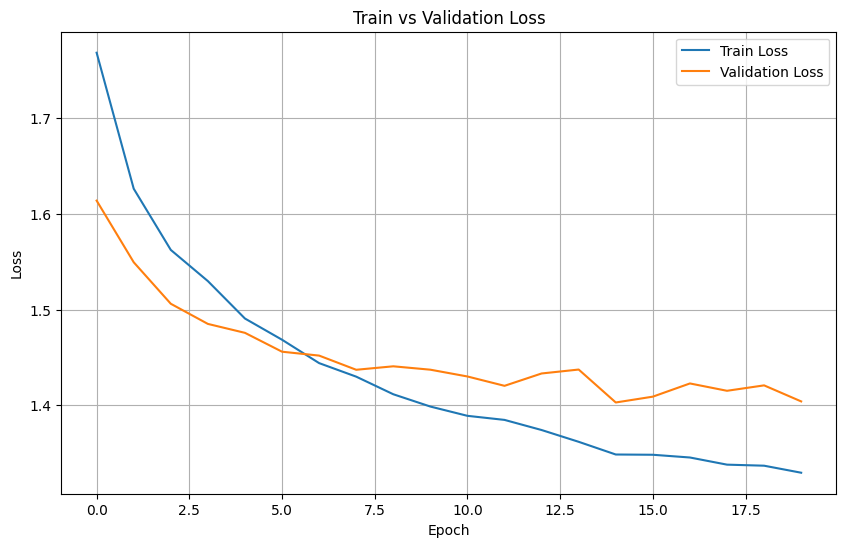

In [29]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
print(device)

cuda


In [31]:
#@title Defining metrics helper

def get_scores(targets, predictions):
    return {
        "accuracy": metrics.accuracy_score(targets, predictions),
        "balanced_accuracy": metrics.balanced_accuracy_score(targets, predictions),
        "precision": metrics.precision_score(targets, predictions, average="weighted"),
        "recall": metrics.recall_score(targets, predictions, average="weighted"),
        "f1_score": metrics.f1_score(targets, predictions, average="weighted")
    }

In [32]:
#@title Evaluate model (accuracy, precision, recall)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mlp = MLP(32*32*3,
          hidden1= hidden1,
          hidden2= hidden2,
          num_classes = 10,
          activation_function = activation_function)

mlp.to(device)

if os.path.exists("melhor_modelo.pth"):
    mlp.load_state_dict(torch.load("melhor_modelo.pth"))
    print("Pesos carregados com sucesso.")
else:
    print("Arquivo de pesos não encontrado. Modelo será inicializado do zero.")

mlp.eval()
predictions = []
labels = []
for images, label in val_loader:
  images = images.view(-1,32*32*3).to(device)
  label = label.to(device)

  output = mlp(images)
  _, predicted = torch.max(output,1)

  predictions.extend(predicted.cpu().numpy())
  labels.extend(label.cpu().numpy())

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

Pesos carregados com sucesso.


Scores of your model
 {'accuracy': 0.5052, 'balanced_accuracy': 0.5052, 'precision': 0.5184337339451633, 'recall': 0.5052, 'f1_score': 0.500145069759003}


# You can change/optimize this as you want
- Different optimizers, activation functions, etc
- Automatic hyperparameters optimization (Optuna)
- Regularization techniques
- Validation set to track metrics during epochs
- Transform input data
- ...